<a href="https://colab.research.google.com/github/LaurentTits/ResponsibleTrainingDeepLearning/blob/main/Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


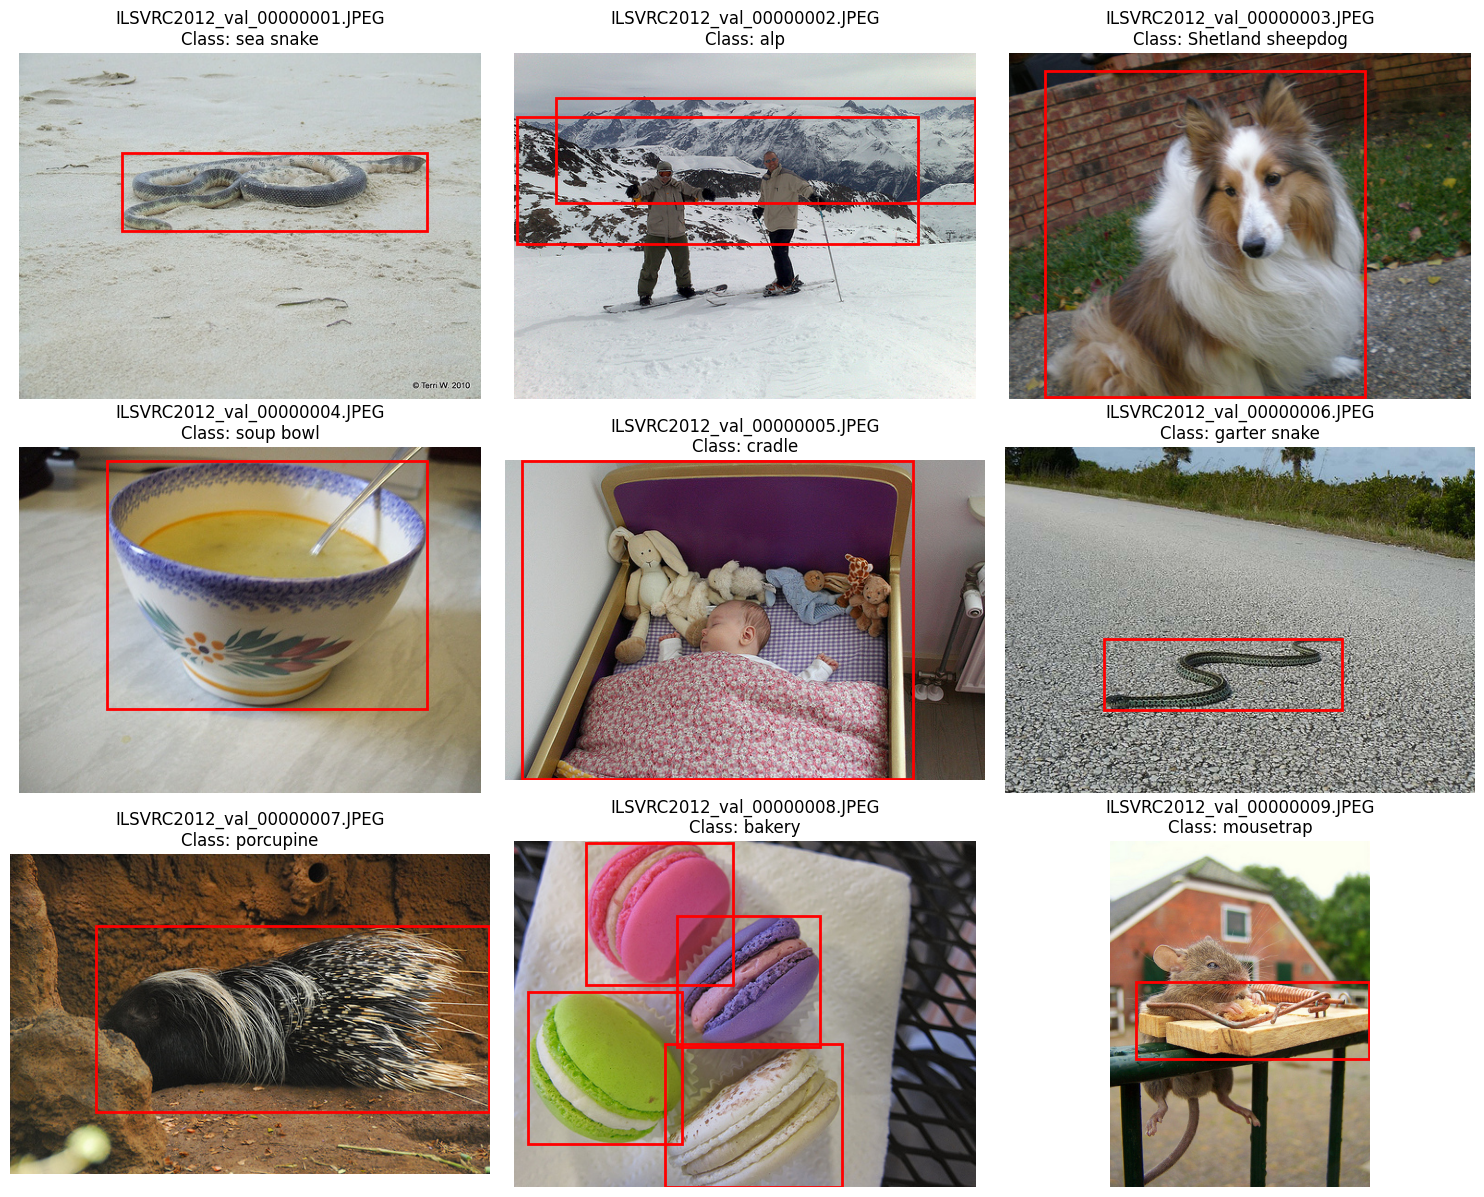

In [8]:
import os
import tarfile
import json
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define dataset paths
dataset_folder = '/content/drive/My Drive/ResponsibleTraining/Datasets'
images_tar_path = os.path.join(dataset_folder, 'ILSVRC2012_img_val.tar')
bbox_tgz_path = os.path.join(dataset_folder, 'ILSVRC2012_bbox_val_v3.tgz')
extract_path = '/content/ILSVRC2012_val'
bbox_extract_path = '/content/ILSVRC2012_bbox/val'

# Load ImageNet class mapping
!wget -q -O imagenet_class_index.json https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json
with open('imagenet_class_index.json', 'r') as f:
    class_mapping = json.load(f)

# Convert WordNet ID to readable class name
def get_class_name(wnid):
    for key, value in class_mapping.items():
        if value[0] == wnid:
            return value[1].replace('_', ' ')
    return 'Unknown'

# Extract images if not already extracted
if not os.path.exists(extract_path):
    os.makedirs(extract_path, exist_ok=True)
    with tarfile.open(images_tar_path, 'r') as tar:
        tar.extractall(path=extract_path)

# Extract bounding boxes if not already extracted
if not os.path.exists(bbox_extract_path):
    os.makedirs(bbox_extract_path, exist_ok=True)
    with tarfile.open(bbox_tgz_path, 'r:gz') as tar:
        tar.extractall(path='/content/ILSVRC2012_bbox')

# Get sorted list of image files
image_files = sorted([f for f in os.listdir(extract_path) if f.endswith('.JPEG')])

# Display first 9 images with bounding boxes (3x3 grid)
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for i in range(9):
    image_path = os.path.join(extract_path, image_files[i])
    image_name = os.path.splitext(image_files[i])[0]  # Remove .JPEG
    annotation_path = os.path.join(bbox_extract_path, f'{image_name}.xml')

    if not os.path.exists(annotation_path):
        print(f'Annotation not found for {image_files[i]}')
        continue

    # Load image
    img = Image.open(image_path)

    # Parse XML annotation
    tree = ET.parse(annotation_path)
    root = tree.getroot()

    # Get class name
    wnid = root.find('object/name').text if root.find('object/name') is not None else 'Unknown'
    class_name = get_class_name(wnid)

    # Plot image
    axes[i].imshow(img)
    axes[i].set_title(f'{image_files[i]}\nClass: {class_name}')

    # Draw bounding boxes
    for obj in root.findall('object'):
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
        axes[i].add_patch(rect)

    axes[i].axis('off')

plt.tight_layout()
plt.show()
